In [20]:
%run preamble_notebooks.py

In [21]:
expo = 100
# Setting the true model
f1, f2 = bs.loss_model("Gamma", ["r1", "m1"]), bs.loss_model("Lomax", ["α2", "σ2"])
f_true = bs.spliced_loss_model(f1, f2, "continuous")
parms_true = np.array([1/2, 1, 2.5, 3, 1.5])
f_true.set_ppf(), f_true.set_pdf(),f_true.set_cdf()

# We set the priority to the 90% quantile and the limit to the 0.99% quantile
P, L = f_true.ppf(parms_true, 0.9), f_true.ppf(parms_true, 0.99)
premiums = f_true.PP(parms_true), f_true.XOLP(parms_true, P, L)

PnLs = np.array(f_true.PnL(parms_true, P, L, expo, premiums, safety_loadings = [0.05, 0.05], n_sim = 1e5))

In [22]:
true_VaRs = [f_true.ppf(parms_true, prob) for prob in [0.95, 0.99, 0.995]]
true_cap = np.quantile(PnLs, [0.005, 0.01, 0.05])
true_cap

array([-101.52452526,  -73.7944115 ,  -28.85287996])

In [174]:
k, nobs = 2, 2000 
s = (well_spec_df["sim"] == k).values & (well_spec_df["nobs"] == nobs).values
sorted_df = well_spec_df[s].sort_values("posterior_probability", ascending = False) 
# selected_models = sorted_df.iloc[np.cumsum(sorted_df["posterior_probability"].values) < 0.99]
# selected_models = sorted_df[:1]
selected_models = sorted_df[sorted_df.model_name == "Gamma_Lomax_continuous"]
model_names_s = selected_models.model_name
# print(model_names_s.values)
model_weights_s = selected_models.posterior_probability
# model_names_s.sample(int(1e5), weights = model_weights_s, replace = True)
traces = []
for model_name in model_names_s.values:
    f, prior, X = f_spliced_dic[model_name], prior_dic[model_name], Xs_2000[k]
    %time trace, log_marg, DIC, WAIC = bs.smc(X, f, 100, prior, verbose = False)
    traces.append(trace)
trace_dic = dict(zip(model_names_s.values, traces))


Wall time: 2.88 s


In [175]:
def compute_cap(model_names_s, f_spliced_dic, trace_dic):
    PNLS_post = []
    for i in range(int(1e5)):
        model_name = model_names_s.sample(1, weights = model_weights_s, replace = True).iloc[0]
        f = f_spliced_dic[model_name]
        # PNLS_post.append( f.PnL(trace_dic[model_name].sample().values[0], P, L, expo, premiums, n_sim = 1)[0])
        PNLS_post.append( f.PnL(trace_dic[model_name].sample().values[0], P, L, expo, premiums, n_sim = 1)[0])
    return(np.quantile(PNLS_post, [0.005, 0.01, 0.05]))
# trace.sample(1).values
# print(int(1e2))
%time false_cap = compute_cap(model_names_s, f_spliced_dic, trace_dic)

Wall time: 2min 52s


In [176]:
false_cap, true_cap

(array([-412.55238986, -266.3526931 ,  -86.02485927]),
 array([-101.52452526,  -73.7944115 ,  -28.85287996]))

<AxesSubplot:xlabel='nobs', ylabel='posterior_probability'>

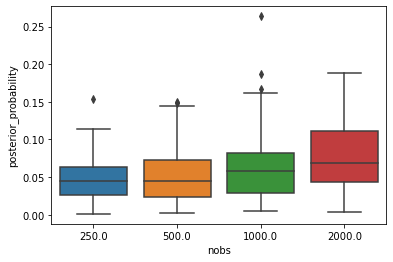

In [5]:
df = well_spec_df[well_spec_df.model_name == "Gamma_Lomax_continuous"]
sns.boxplot(x = "nobs", y = "posterior_probability", data = df)

In [23]:
s = (well_spec_df["sim"] == 0).values & (well_spec_df["nobs"] == 250).values
sorted_df = well_spec_df[s].sort_values("posterior_probability", ascending = False) 
print(sorted_df[:5])
len(sorted_df.iloc[np.cumsum(sorted_df["posterior_probability"].values) < 0.08].model_name.values)
# df = np.cumsum(
#     well_spec_df[s].sort_values("posterior_probability")
#                .values)
# df
# list_model_names = df.groupby(by = ["model_name"]).count()


     Unnamed: 0  sim                       model_name   nobs     γ_map  \
25           25    0         Weibull_Lomax_continuous  250.0  0.860306   
14           14    0           Gamma_Lomax_continuous  250.0  1.034125   
91           91    0    Log-Logistic_Lomax_continuous  250.0  0.592505   
102         102    0            Burr_Lomax_continuous  250.0  0.591432   
24           24    0  Weibull_Log-Logistic_continuous  250.0  1.115364   

       log_marg   Wass_dist       q95        q99       q995  \
25  -126.909228  116.953093  4.485319  14.941451  24.448585   
14  -127.014447  119.910645  4.728543  15.785808  25.800006   
91  -127.268331  114.566108  3.992896  13.470922  22.104853   
102 -127.453255  112.287368  4.063541  13.829835  22.809095   
24  -127.504308  123.209934  4.745592  17.265049  29.759135   

     posterior_probability  
25                0.076956  
14                0.069271  
91                0.053739  
102               0.044666  
24                0.042443  


1

In [ ]:
df = well_spec_df[well_spec_df["posterior_probability"] > 0.1]
df.groupby(by = ["model_name", "nobs"]).count()